<a href="https://colab.research.google.com/github/naufalrafianto/API-Auth/blob/main/FP_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [142]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

###Import Dataset


In [143]:
df = pd.read_csv('./labeled_data.csv', index_col=0)

###1. Data Understanding


In [144]:
print("Data Shape: ", df.shape)

Data Shape:  (24783, 6)


In [145]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24783 entries, 0 to 25296
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   count               24783 non-null  int64 
 1   hate_speech         24783 non-null  int64 
 2   offensive_language  24783 non-null  int64 
 3   neither             24783 non-null  int64 
 4   class               24783 non-null  int64 
 5   tweet               24783 non-null  object
dtypes: int64(5), object(1)
memory usage: 1.3+ MB


In [146]:
df[["count", "hate_speech"]].describe()

,count,hate_speech
count,24783.000000,24783.000000
mean,3.243473,0.280515
std,0.883060,0.631851
min,3.000000,0.000000
25%,3.000000,0.000000
50%,3.000000,0.000000
75%,3.000000,0.000000
max,9.000000,7.000000


In [147]:
print("\nSample data:")
df.head()


Sample data:


,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [148]:
df['class'].value_counts()

,count
class,
1,19190
2,4163
0,1430


In [149]:
def balance_classes(df, target_size=1430):
    # Create empty dataframe to store balanced data
    balanced_df = pd.DataFrame()

    # For each class
    for class_label in df['class'].unique():
        # Get all samples of current class
        class_data = df[df['class'] == class_label]

        # If class has more samples than target_size, randomly sample down
        if len(class_data) > target_size:
            class_data = class_data.sample(n=target_size, random_state=42)

        # Add to balanced dataframe
        balanced_df = pd.concat([balanced_df, class_data])

    # Shuffle the final dataframe
    balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

    return balanced_df

df = balance_classes(df)


###2. Cleaning Data

In [150]:
df.isnull().sum()

,0
count,0
hate_speech,0
offensive_language,0
neither,0
class,0
tweet,0


In [151]:
df.duplicated().sum()

0

###3. Exploratory Data Analysis (EDA)

#####3.1 Analisis Distribusi Kelas

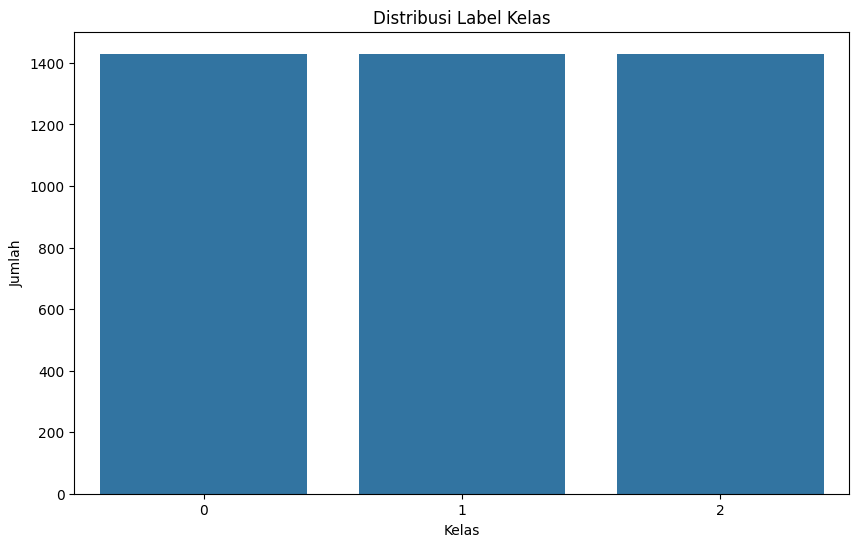


Distribusi kelas:
class
0    1430
1    1430
2    1430
Name: count, dtype: int64

Persentase distribusi:
class
0    33.3
1    33.3
2    33.3
Name: proportion, dtype: float64


In [152]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='class')
plt.title('Distribusi Label Kelas')
plt.xlabel('Kelas')
plt.ylabel('Jumlah')
plt.show()

print("\nDistribusi kelas:")
print(df['class'].value_counts())
print("\nPersentase distribusi:")
print(df['class'].value_counts(normalize=True).round(3) * 100)

#####3.2 Analisis Komponen Label

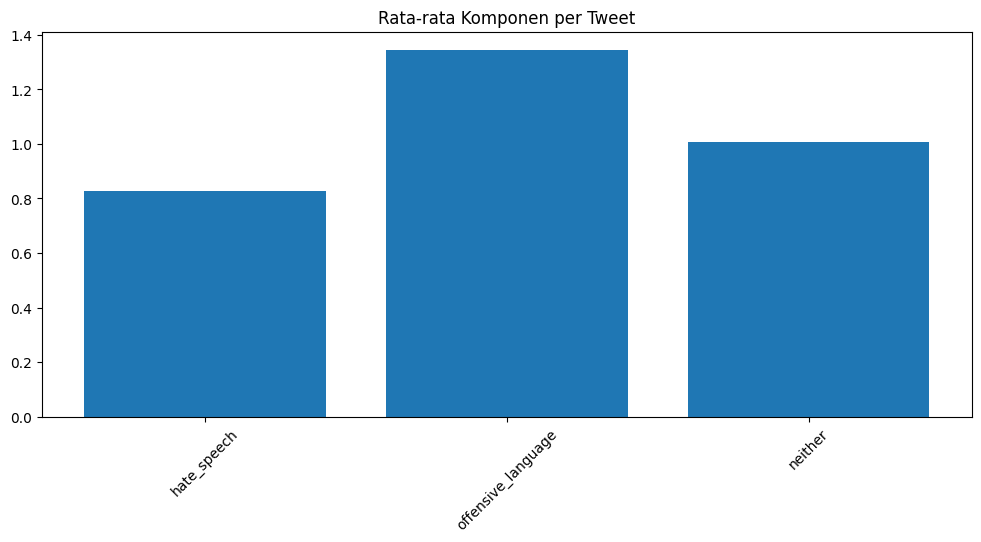

In [153]:
plt.figure(figsize=(12, 5))
components = ['hate_speech', 'offensive_language', 'neither']
averages = [df[col].mean() for col in components]
plt.bar(components, averages)
plt.title('Rata-rata Komponen per Tweet')
plt.xticks(rotation=45)
plt.show()

#####3.3 Analisis Korelasi


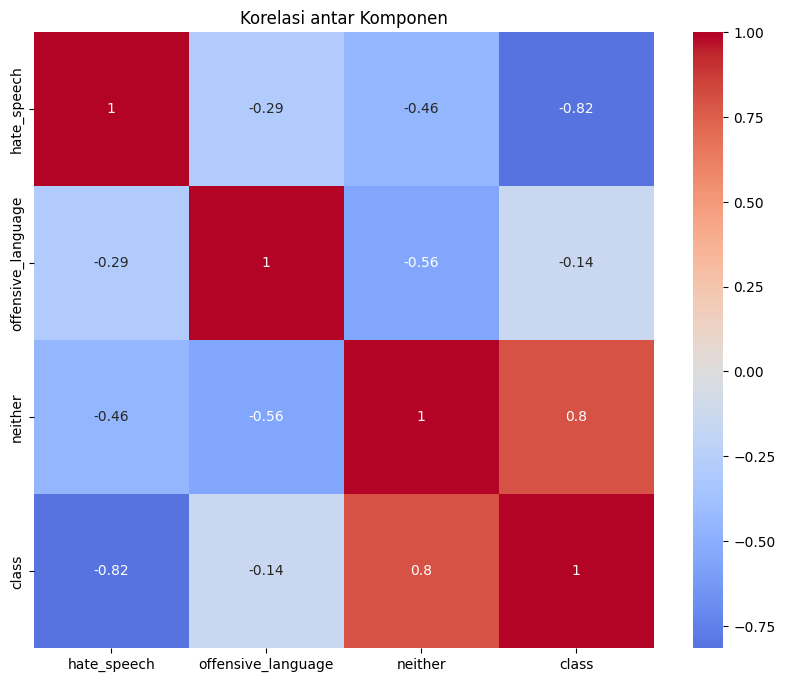

In [154]:
corr_cols = ['hate_speech', 'offensive_language', 'neither', 'class']
corr_matrix = df[corr_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Korelasi antar Komponen')
plt.show()

###4. Text Preprocessing

#####4.1 Download NLTK stopwords

In [155]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


######4.2 Fungsi Preprocessing

In [156]:
def clean_text(text):
    """
    Membersihkan teks:
    - Mengubah ke lowercase
    - Menghapus karakter khusus
    - Menghapus angka
    - Menghapus spasi berlebih
    """
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = ' '.join(text.split())
    return text

def remove_stopwords(text):
    """Menghapus stopwords"""
    words = text.split()
    words = [w for w in words if w not in stop_words]
    return ' '.join(words)

In [157]:
df['cleaned_text'] = df['tweet'].apply(clean_text)
df['cleaned_text'] = df['cleaned_text'].apply(remove_stopwords)

In [158]:
print("Contoh hasil preprocessing:")
for i in range(3):
    print(f"\nOriginal: {df['tweet'].iloc[i]}")
    print(f"Cleaned : {df['cleaned_text'].iloc[i]}")

Contoh hasil preprocessing:

Original: Brady heard yall say he was washed, now he washing the league on you hoe ass niggas.
Cleaned : brady heard yall say washed washing league hoe ass niggas

Original: @WendyDavisTexas msnbc the same MSM who said blocking flights from africa is racist yea right No ID no vote bitch gold digger
Cleaned : wendydavistexas msnbc msm said blocking flights africa racist yea right id vote bitch gold digger

Original: @JasonMoriarty13 I remember his nephew Lucas crying and dan saying "quit being such a pussy and grow a pair" or something. &#128514;&#128557; dans so funny.
Cleaned : jasonmoriarty remember nephew lucas crying dan saying quit pussy grow pair something dans funny


###5. Analisis Teks

######5.1 Analisis Panjang Tweet

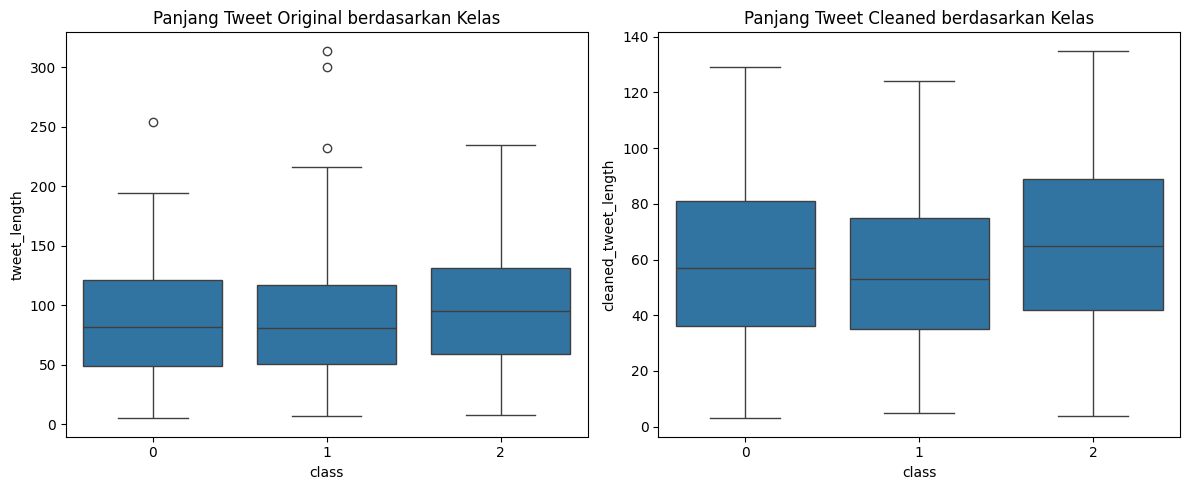

In [159]:
# Ensure the columns are of string type
df['tweet'] = df['tweet'].astype(str)
df['cleaned_text'] = df['cleaned_text'].astype(str)

# Add tweet length columns
df['tweet_length'] = df['tweet'].str.len()
df['cleaned_tweet_length'] = df['cleaned_text'].str.len()

# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(data=df, x='class', y='tweet_length')
plt.title('Panjang Tweet Original berdasarkan Kelas')

plt.subplot(1, 2, 2)
sns.boxplot(data=df, x='class', y='cleaned_tweet_length')
plt.title('Panjang Tweet Cleaned berdasarkan Kelas')
plt.tight_layout()
plt.show()

#####5.2 Analisis Word Frequency

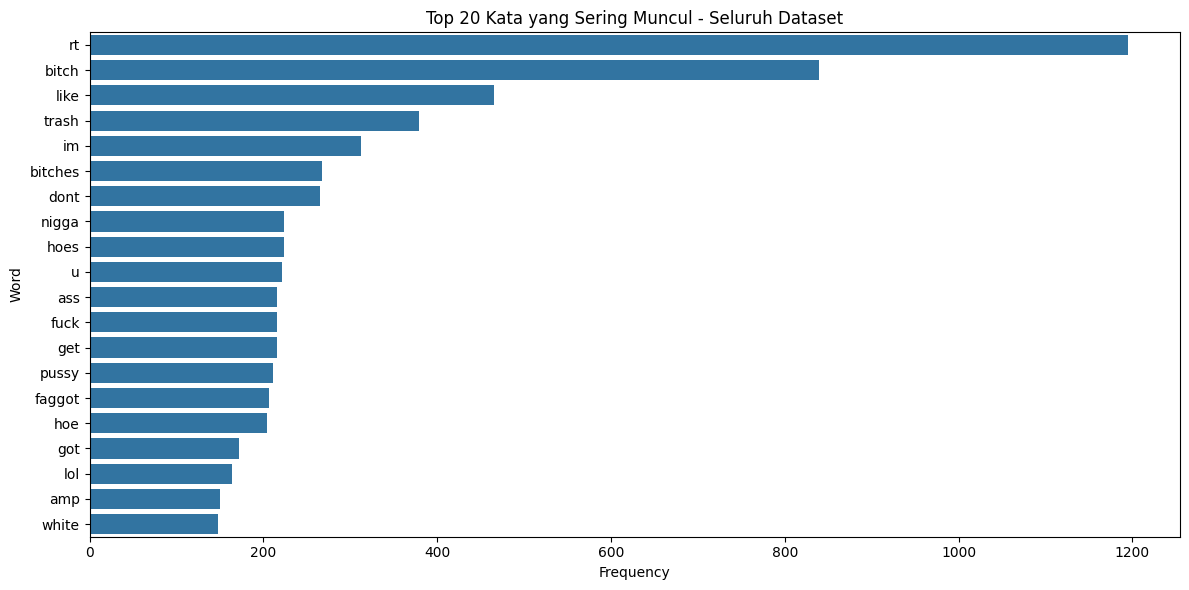

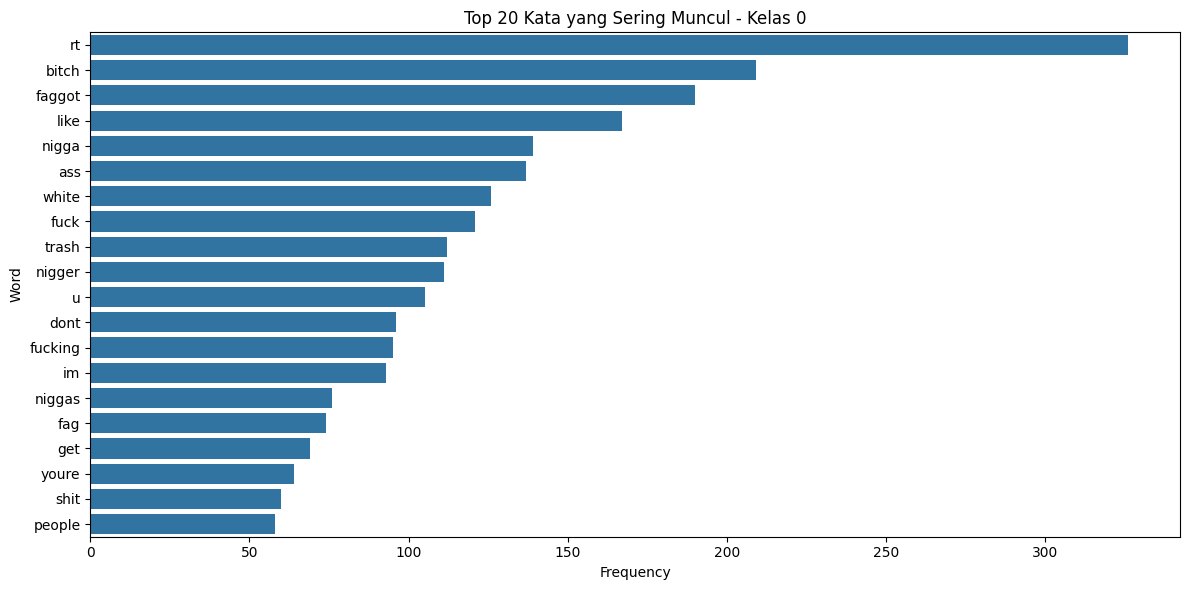

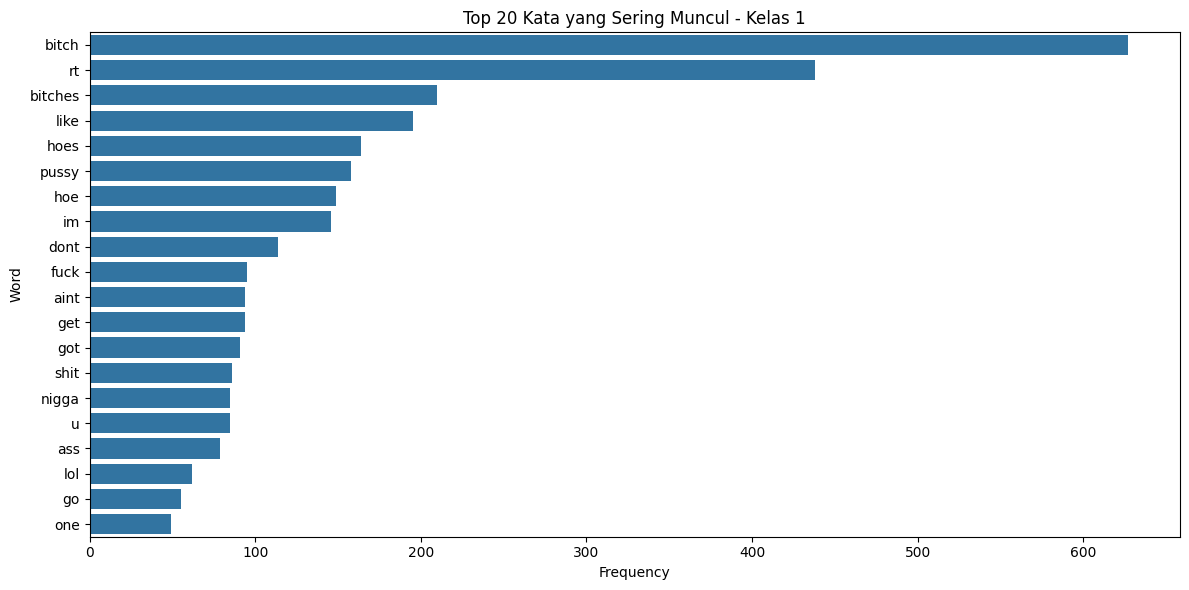

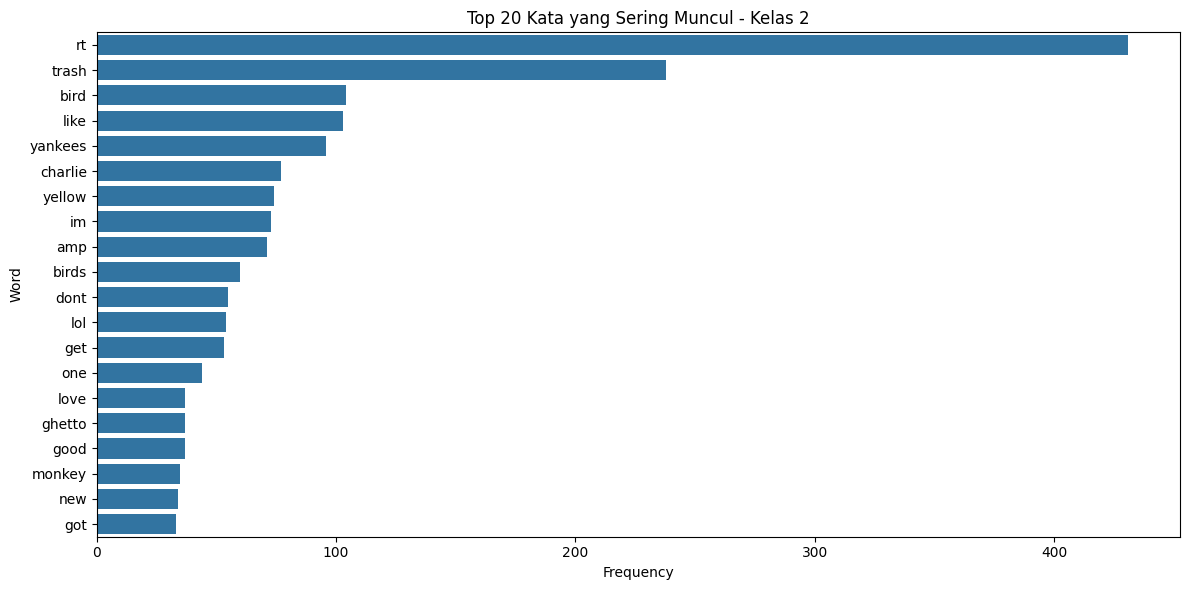

In [160]:
def plot_word_frequency(texts, title, n=20):
    words = ' '.join(texts).split()
    word_freq = Counter(words)

    plt.figure(figsize=(12, 6))
    word_freq_df = pd.DataFrame(word_freq.most_common(n), columns=['Word', 'Frequency'])
    sns.barplot(data=word_freq_df, x='Frequency', y='Word')
    plt.title(f'Top {n} Kata yang Sering Muncul - {title}')
    plt.tight_layout()
    plt.show()

plot_word_frequency(df['cleaned_text'], 'Seluruh Dataset')

# Plot word frequency untuk setiap kelas
for class_label in df['class'].unique():
    class_texts = df[df['class'] == class_label]['cleaned_text']
    plot_word_frequency(class_texts, f'Kelas {class_label}')

###6. Feature Extraction dan Split Data

#####6.1 Split data

In [161]:
X = df['cleaned_text']
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#####6.2 TF-IDF Vectorization

In [162]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print("Bentuk data setelah vektorisasi:")
print(f"Training: {X_train_tfidf.shape}")
print(f"Testing : {X_test_tfidf.shape}")


Bentuk data setelah vektorisasi:
Training: (3432, 5000)
Testing : (858, 5000)


###7. Model Training

#####7.1 Inisialisasi dan training model

In [163]:
svm_model = LinearSVC(random_state=42)
svm_model.fit(X_train_tfidf, y_train)


LinearSVC(random_state=42)

#####7.2 Evaluasi Model


Laporan Klasifikasi:
              precision    recall  f1-score   support

           0       0.79      0.71      0.74       296
           1       0.76      0.79      0.78       294
           2       0.84      0.90      0.87       268

    accuracy                           0.79       858
   macro avg       0.80      0.80      0.80       858
weighted avg       0.79      0.79      0.79       858



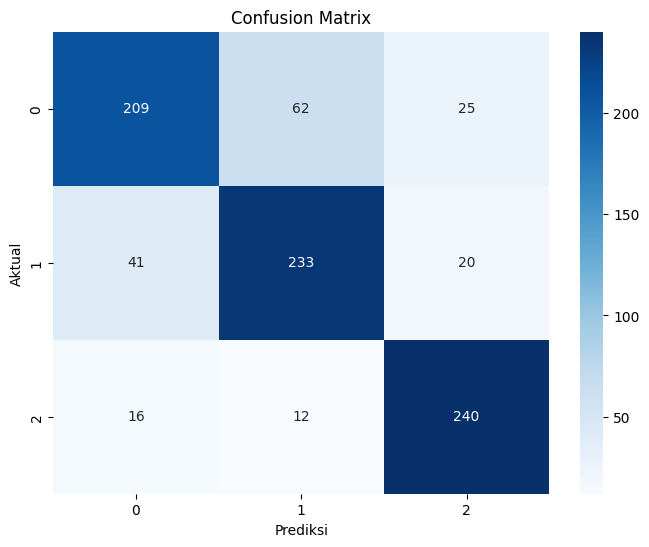

In [164]:
y_pred = svm_model.predict(X_test_tfidf)

# Classification Report
print("\nLaporan Klasifikasi:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.show()

###8. Fungsi Prediksi

In [165]:
def predict_text(text, vectorizer, model):
    # Preprocessing
    cleaned = clean_text(text)
    cleaned = remove_stopwords(cleaned)
    # Vectorize
    vector = vectorizer.transform([cleaned])
    # Predict
    prediction = model.predict(vector)
    return prediction[0]

###### 8.1 Contoh penggunaan

In [166]:
sample_texts = [
    "I love you all!",
    "I hate you all!",
    "You are a terrible person",
    "Have a great day!"
]

print("\nContoh Prediksi:")
for text in sample_texts:
    pred = predict_text(text, vectorizer, svm_model)
    print(f"\nText: {text}")
    print(f"Prediksi: Kelas {pred}")


Contoh Prediksi:

Text: I love you all!
Prediksi: Kelas 2

Text: I hate you all!
Prediksi: Kelas 0

Text: You are a terrible person
Prediksi: Kelas 2

Text: Have a great day!
Prediksi: Kelas 2


###9. Model Improvement and Cross-Validation


In [167]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier


######9.1 Cross Validation


In [168]:
def perform_cross_validation(model, X, y, cv=5):
    cv_scores = cross_val_score(model, X, y, cv=cv)
    print(f"\nCross Validation Scores: {cv_scores}")
    print(f"Mean CV Score: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

# Perform cross-validation
perform_cross_validation(LinearSVC(random_state=42), X_train_tfidf, y_train)



Cross Validation Scores: [0.76419214 0.76855895 0.77113703 0.80174927 0.78425656]
Mean CV Score: 0.778 (+/- 0.027)


#####9.2 Hyperparameter Tuning

In [169]:
param_grid = {
    'C': [0.1, 1, 10],
    'loss': ['hinge', 'squared_hinge'],
    'max_iter': [1000]
}

grid_search = GridSearchCV(
    LinearSVC(random_state=42),
    param_grid,
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_tfidf, y_train)

print("\nBest parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Train model with best parameters
best_model = grid_search.best_estimator_
best_model.fit(X_train_tfidf, y_train)
y_pred_best = best_model.predict(X_test_tfidf)

print("\nClassification Report with Best Model:")
print(classification_report(y_test, y_pred_best))


Fitting 5 folds for each of 6 candidates, totalling 30 fits

Best parameters: {'C': 1, 'loss': 'hinge', 'max_iter': 1000}
Best cross-validation score: 0.8007053101964429

Classification Report with Best Model:
              precision    recall  f1-score   support

           0       0.85      0.70      0.77       296
           1       0.78      0.83      0.80       294
           2       0.83      0.94      0.88       268

    accuracy                           0.82       858
   macro avg       0.82      0.82      0.82       858
weighted avg       0.82      0.82      0.82       858



###10. Error Analysis


Sample Error Cases:
                                                text  true_label  \
0               many bitches one sentence fixitjesus           0   
1  georgiathenewsa rosaalbae tits may better look...           0   
2  rt ladyblahblah furrybah paypay voice rt sbaby...           0   
3  egotheicon everytime pro teams gb tourneys get...           2   
4  truuuuuuuuuuu facts niggaz pussy nd ill tag em...           1   

   predicted_label  
0                1  
1                2  
2                1  
3                1  
4                0  


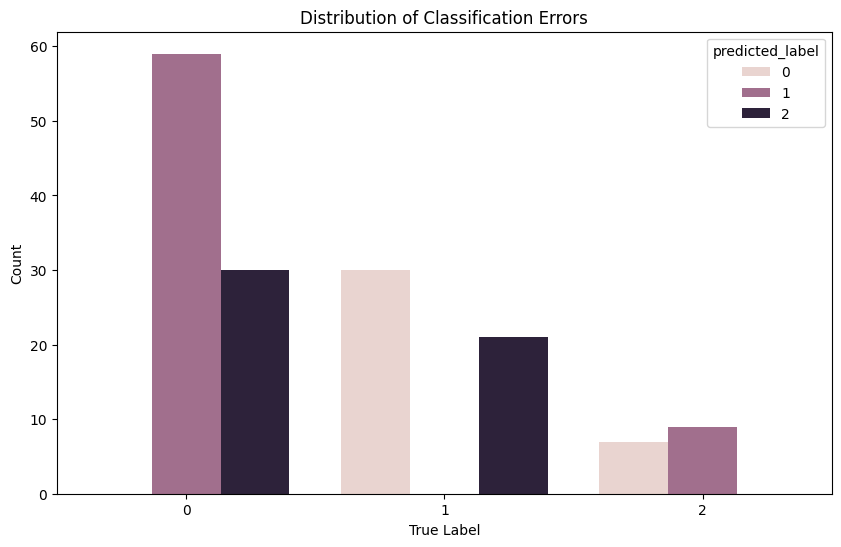

In [170]:
def analyze_errors(y_true, y_pred, X_text):
    errors = []
    for true, pred, text in zip(y_true, y_pred, X_text):
        if true != pred:
            errors.append({
                'text': text,
                'true_label': true,
                'predicted_label': pred
            })
    return pd.DataFrame(errors)

# Get error cases
error_df = analyze_errors(y_test.values, y_pred_best, X_test.values)

print("\nSample Error Cases:")
print(error_df.head())

# Analyze error distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=error_df, x='true_label', hue='predicted_label')
plt.title('Distribution of Classification Errors')
plt.xlabel('True Label')
plt.ylabel('Count')
plt.show()

###11. Feature Importance Analysis

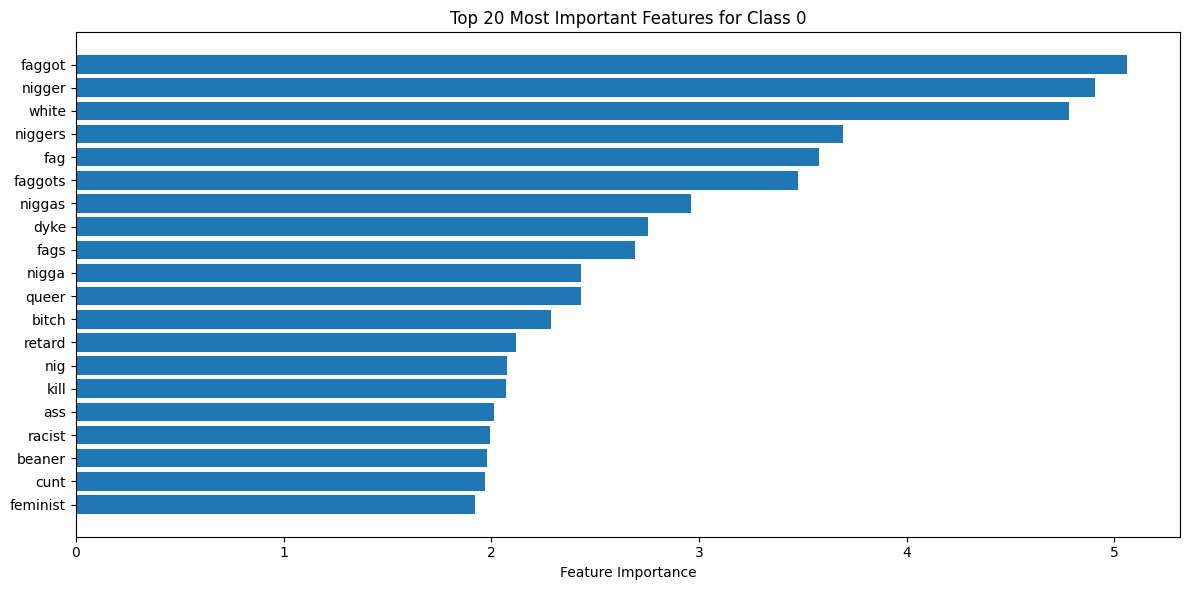

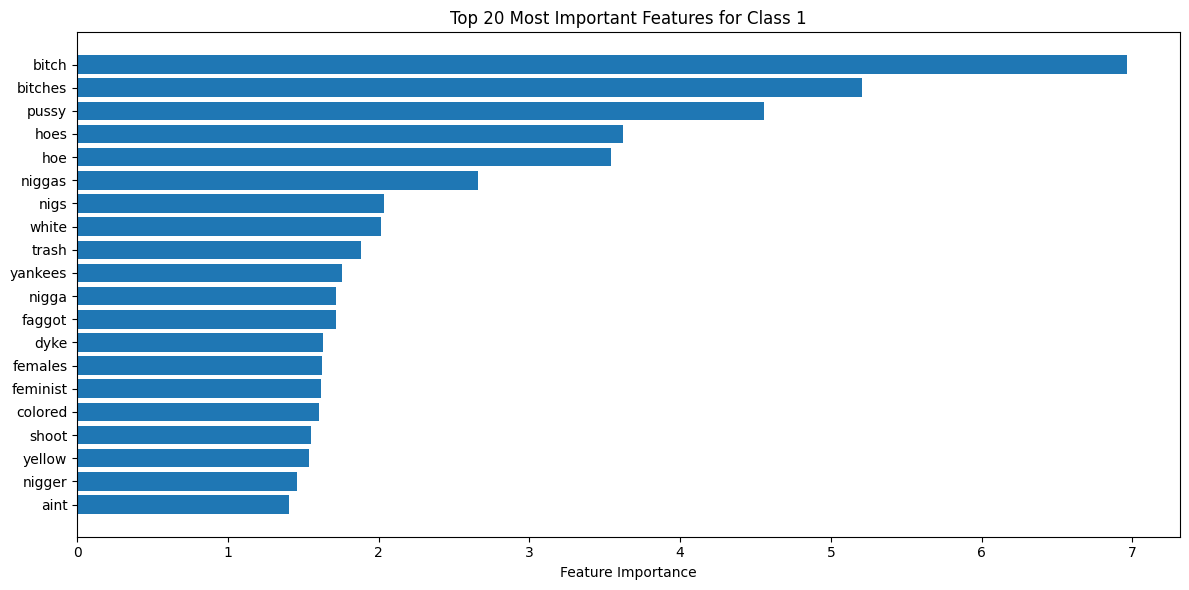

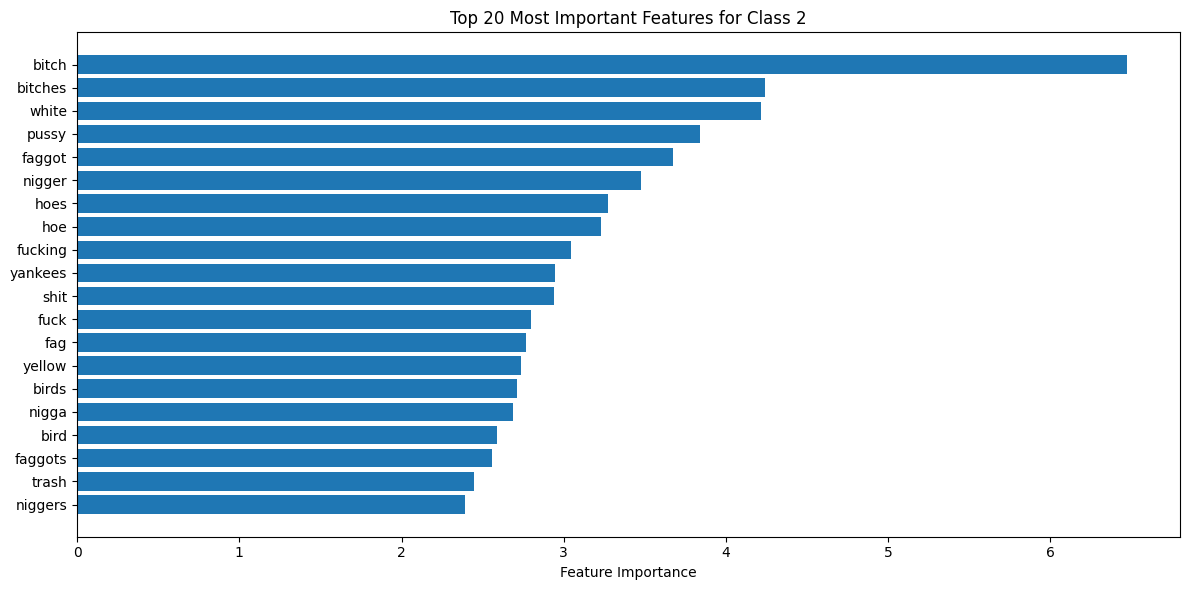

In [171]:
def get_feature_importance(vectorizer, model, n_top=20):
    feature_names = vectorizer.get_feature_names_out()

    if hasattr(model, 'coef_'):
        importance = np.abs(model.coef_)
    else:
        return None

    for i, class_importance in enumerate(importance):
        plt.figure(figsize=(12, 6))
        top_indices = np.argsort(class_importance)[-n_top:]
        top_features = feature_names[top_indices]
        top_importance = class_importance[top_indices]

        plt.barh(range(n_top), top_importance)
        plt.yticks(range(n_top), top_features)
        plt.title(f'Top {n_top} Most Important Features for Class {i}')
        plt.xlabel('Feature Importance')
        plt.tight_layout()
        plt.show()

# Analyze feature importance
get_feature_importance(vectorizer, best_model)

###12. Model Deployment Preparation

In [172]:
import pickle

In [173]:
def save_model(model, vectorizer, model_filename='hate_speech_model.pkl',
               vectorizer_filename='vectorizer.pkl'):
    # Save the model
    with open(model_filename, 'wb') as file:
        pickle.dump(model, file)

    # Save the vectorizer
    with open(vectorizer_filename, 'wb') as file:
        pickle.dump(vectorizer, file)

    print("Model and vectorizer saved successfully!")

def load_model(model_filename='hate_speech_model.pkl',
               vectorizer_filename='vectorizer.pkl'):
    # Load the model
    with open(model_filename, 'rb') as file:
        model = pickle.load(file)

    # Load the vectorizer
    with open(vectorizer_filename, 'rb') as file:
        vectorizer = pickle.load(file)

    return model, vectorizer

# Save the model and vectorizer
save_model(best_model, vectorizer)

Model and vectorizer saved successfully!


###13. Create Prediction Pipeline


In [174]:
class HateSpeechClassifier:
    def __init__(self, model, vectorizer):
        self.model = model
        self.vectorizer = vectorizer

    def preprocess_text(self, text):
        cleaned = clean_text(text)
        cleaned = remove_stopwords(cleaned)
        return cleaned

    def predict(self, text):
        # Preprocess
        cleaned_text = self.preprocess_text(text)
        # Vectorize
        vector = self.vectorizer.transform([cleaned_text])
        # Predict
        prediction = self.model.predict(vector)[0]
        # Get probability scores
        # Note: LinearSVC doesn't provide probability scores directly
        decision_scores = self.model.decision_function(vector)

        return {
            'prediction': int(prediction),
            'decision_scores': decision_scores.tolist(),
            'preprocessed_text': cleaned_text
        }

# Create classifier instance
classifier = HateSpeechClassifier(best_model, vectorizer)

# Test the pipeline
test_texts = [
    "You are amazing!",
    "I hate everyone",
    "This is a neutral statement",
    "You're absolutely worthless"
]

print("\nTest Predictions:")
for text in test_texts:
    result = classifier.predict(text)
    print(f"\nText: {text}")
    print(f"Prediction: Class {result['prediction']}")
    print(f"Decision Scores: {result['decision_scores']}")


Test Predictions:

Text: You are amazing!
Prediction: Class 2
Decision Scores: [[-0.598925294809439, -0.7609314510521206, 0.16348090349124536]]

Text: I hate everyone
Prediction: Class 0
Decision Scores: [[-0.17308289808415772, -0.9864678470634278, -0.34588743769133135]]

Text: This is a neutral statement
Prediction: Class 2
Decision Scores: [[-0.598925294809439, -0.7609314510521206, 0.16348090349124536]]

Text: You're absolutely worthless
Prediction: Class 0
Decision Scores: [[-0.24787861434326708, -0.3864852947127968, -0.5646623117312288]]
